In [1]:
from sqlalchemy import create_engine
from operator import itemgetter
import json
import math
import time

import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import linear_model
from skopt import gp_minimize
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=6, suppress=True)

In [38]:
category = 'R'
# category = 'G'
# category = 'H'

bet_type = 'W'
# bet_type = 'P'

pred = '{}_pred'.format(bet_type)
prob = '{}_prob'.format(bet_type)
bet = '{}_bet'.format(bet_type)

In [39]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()

dfoo = pd.read_sql_table('race', conn)
print('{} races loaded!'.format(len(dfoo)))

21699 races loaded!


In [40]:
dfo = dfoo.loc[dfoo['race_type'].isin([category])]
print('{} {} races for {} betting!'.format(len(dfo), category, bet_type))

7057 R races for W betting!


In [41]:
dfo['results'] = dfo['results_data'].map(json.loads)
dfo['runners'] = dfo['runners_data'].map(json.loads)
dfo.tail(2)

/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,meeting_name,location,venue_mnemonic,race_type,meeting_date,race_number,race_name,race_start_time,race_status,race_distance,results_data,num_runners,runners_data,quinella,exacta,trifecta,first_four,results,runners
21697,25810,HAYDOCK PK,GBR,K,R,2017-07-22,1,BETFRED FILLIES' HANDICAP,2017-07-22 16:55:00,Paying,1000,"[[12], [7], [3], []]",12,"[{""runnerName"": ""ROSE MARMARA"", ""runnerNumber""...",146.7,0.0,0.0,NaN,"[[12], [7], [3], []]","[{'runnerName': 'ROSE MARMARA', 'runnerNumber'..."
21698,25811,HAYDOCK PK,GBR,K,R,2017-07-22,2,BETFRED GREAT VALUE EVERY DAY HCP,2017-07-22 17:30:00,Paying,2000,"[[5], [8], [3], []]",12,"[{""runnerName"": ""LOPITO DE VEGA"", ""runnerNumbe...",14.4,17.6,121.9,NaN,"[[5], [8], [3], []]","[{'runnerName': 'LOPITO DE VEGA', 'runnerNumbe..."


In [42]:
# bet size
balance = 1000
bet_chunk = balance * 0.01

In [43]:
def process_strategy(dfp, strategy, x):
    """run strategy, must pass runners returned back into results (it might be modified)"""
    book = []
    for _, race in dfp.iterrows():
#         print(race['num_runners'])
        runners = race['runners']
        
        # drop scratched
        runners = [r for r in runners if r['has_odds']]
        if not runners:
            continue
    
        # default 0 bets
        for runner in runners:
            runner[bet] = 0
        
        runners, num_bets = strategy(runners, bet_chunk, bet_type, x)
        if num_bets:
            bet_results(book, runners, race['num_runners'], bet_chunk, num_bets)
            
    book_df = pd.DataFrame(book)
    return book_df

In [44]:
def bet_results(book, runners, num_runners, bet_chunk, num_bets):
    """get results from bets"""
    place_cutoff = 3 if num_runners >= 8 else 2

    win_diff = 0
    max_diff = 0
    prob2scales = []
    prob0scales = []
    # profit start with loss of bet made
    outcome = {
        'success': 0,
        'profit': -bet_chunk,
        'num_bets': num_bets,
        'num_runners': num_runners,
    }
    for i, runner in enumerate(runners):
        diff = abs(runner['win_scaled'] - runner[prob])
        max_diff = max(max_diff, diff)
        if int(runner['finishingPosition']) == 1:
            win_diff = diff

        if runner[bet]:
            prob2scales.append(runner[prob] / runner['win_scaled'])
            prob0scales.append(runner[prob] - runner['win_scaled'])

            if bet_type == 'W':
                if int(runner['finishingPosition']) == 1:
                    outcome['success'] = 1
                    # profit will be payout added against inital deduction
                    # winnings is the bet made times the odds
                    winnings = runner[bet] * runner['win_odds']
                    outcome['profit'] += winnings
                break
            elif bet_type == 'P':
                if 1 <= int(runner['finishingPosition']) <= place_cutoff:
                    # success is how correct each placement was
                    outcome['success'] += 1 / num_bets
                    # profit will be return added and offset against inital deduction
                    # winnings is the bet made times the odds
                    winnings = runner[bet] * runner['place_odds']
                    outcome['profit'] += winnings

    outcome['max_diff'] = max_diff
    outcome['win_diff'] = win_diff
    outcome['prob2scale_avg'] = sum(prob2scales) / len(prob2scales)
    outcome['prob2scale'] = min(prob2scales)
    outcome['prob0scale'] = min(prob0scales)
    outcome['bet_chunk'] = bet_chunk
#     outcome['runners'] = runners
    
    # add odds curve
#     probs = sorted([r['win_odds'] for r in runners if runner['win_odds']])
#     p = np.polyfit(np.arange(len(probs)), probs, 2)
#     outcome['pa'] = p[0]
#     outcome['pb'] = p[1]
#     outcome['pc'] = p[2]
    
    book.append(outcome)

In [46]:
def bet_positive_dutch(runners, bet_chunk, bet_type, x):
    """dutch betting on probability"""
    pred = '{}_pred'.format(bet_type)
    prob = '{}_prob'.format(bet_type)
    bet = '{}_bet'.format(bet_type)

    # sort runners from favourite to underdog
    runners.sort(key=lambda r: r[pred], reverse=True)
    
    # start betting on all and cut off worse runner till positive outcome
    for num_bets in range(len(runners), 0, -1):

        # reset bets
        for runner in runners:
            runner[bet] = 0

        # recreate smaller pool
        pool = runners[:num_bets]
        # print('pool is {} from {} bets'.format(len(pool), num_bets))

        # all prediction values
        total_preds = sum([r[pred] for r in pool])

        # dutch for all in pool
        profits = []
        scales = []
        for runner in pool:
            # scale bet according to prediction
            runner[bet] = bet_chunk * runner[pred] / total_preds

            # need to check all as we scale to probs and not odds
            if bet_type == 'W':
                odds = runner['win_odds']
                scaled = runner['win_scaled']
            elif bet_type == 'P':
                odds = runner['place_odds']
                scaled = runner['place_scaled']
            profits.append(runner[bet] * odds - bet_chunk)
            scales.append(runner[prob] / scaled)

        ###################################################################################
        # MIN PROFIT
        ###################################################################################
        min_profit_flag = False
        min_profit = min(profits)
        if min_profit > bet_chunk * x[0]:
            min_profit_flag = True

        ###################################################################################
        # MIN SCALED
        ###################################################################################
        min_scaled_flag = False
        min_scaled = min(scales)
        if min_scaled >= x[1]:
            min_scaled_flag = True

        if min_profit_flag and min_scaled_flag:
            # print('breaking: {} {} {} {}'.format(min_profit_flag, avg_profit_flag, num_bets_flag, min_probs2scale_flag))
            break
    else:
        #         print('no profit determined')
        return [], 0

    # put bets from pool into runners
    for p in pool:
        for r in runners:
            if r['runnerNumber'] == p['runnerNumber']:
                r[bet] = p[bet]
                break

    return runners, num_bets

In [59]:
def f(x):
    book_df = process_strategy(dfo, bet_positive_dutch, x)
    #print(book_df)
    if not len(book_df):
        return 0
    profit = book_df.profit.sum()
#     if bet_type == 'W':
#         participation = (len(book_df) ** 2) / (len(dfo) ** 2)
#     else:
#         participation = 1
#     return profit * participation * -1
    return profit / len(dfo) * -1
    

time_start = time.time()

# x0 => min profit
# x1 => min probs2scale
# fail => avg profit

x, *grid = sp.optimize.brute(f, np.s_[-1:3:9, 0.8:1.4:20j], full_output=True)

print('done: took {:.0f}min'.format((time.time() - time_start) / 60))
# print('x: {}'.format(x))
# print('grid: {}'.format(grid))

done: took 2min


In [60]:
print('category: {}'.format(category))
print('bet type: {}'.format(bet_type))
print('x: {}'.format(x))
df = process_strategy(dfo, bet_positive_dutch, x)
print('${:.2f} profit per race'.format(df.profit.sum() / len(dfo)))
print('{:.0f}% of races {} / {}'.format(len(df) / len(dfo) * 100, len(df), len(dfo)))

category: R
bet type: W
x: [ 0.7   5.81]
$0.00 profit per race
0% of races 1 / 7057


/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


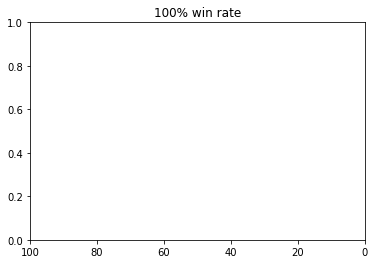

In [61]:
df['ones'] = np.ones(len(df))
df['win_rate'] = df.success.cumsum() / df.ones.cumsum()
win_title = '{:.0f}% win rate'.format(df.win_rate.iloc[-1] * 100)
df.win_rate.plot(title=win_title, xlim=(100), ylim=(0, 1))

/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


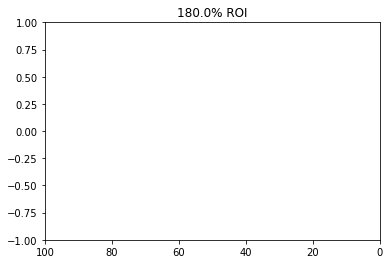

In [62]:
# ROI
roi = df.profit.rolling(20).sum() / df.bet_chunk.rolling(20).sum()
roi.plot(xlim=(100), ylim=(-1, 1), alpha=0.3)
roi = df.profit.cumsum() / df.bet_chunk.cumsum()
roi_title = '{:.1f}% ROI'.format(roi.iloc[-1] * 100)
roi.plot(xlim=(100), ylim=(-1, 1), title=roi_title)

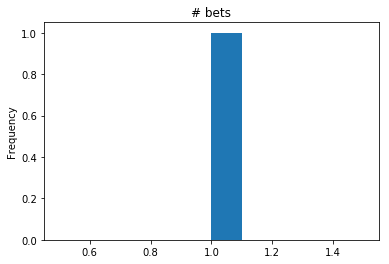

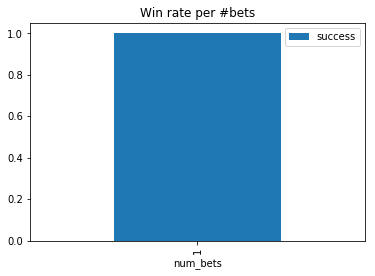

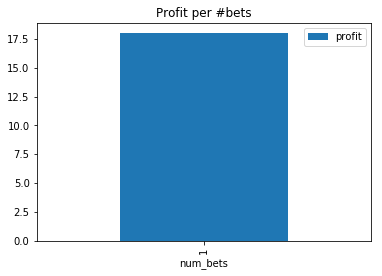

In [63]:
# profit per num bets 
df.num_bets.plot(kind='hist', title='# bets')
groups = df.groupby('num_bets').mean()
groups.plot(kind='bar', y='success', title='Win rate per #bets')
groups.plot(kind='bar', y='profit', title='Profit per #bets')

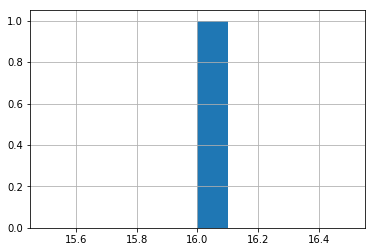

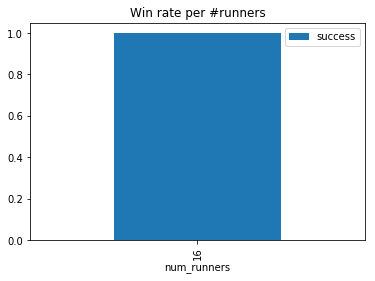

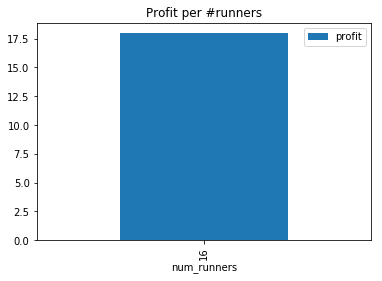

In [64]:
# profit per num runners
df.num_runners.hist()
groups = df.groupby('num_runners').mean()
groups.plot(kind='bar', y='success', title='Win rate per #runners')
groups.plot(kind='bar', y='profit', title='Profit per #runners')

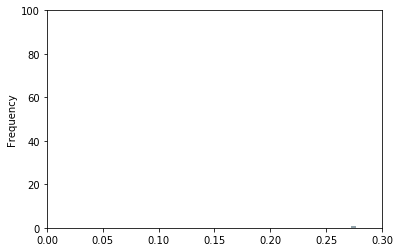

In [65]:
# max diff
df.win_diff.plot(kind='hist', bins=200, alpha=0.6, ylim=(0, 100), xlim=(0, 0.3))
df.max_diff.plot(kind='hist', bins=200, alpha=0.2, ylim=(0, 100), xlim=(0, 0.3))

/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


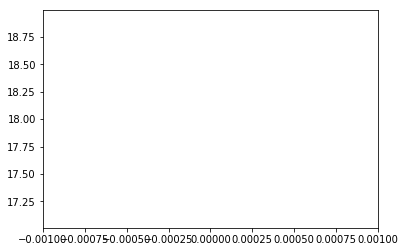

In [66]:
# df.profit.plot(kind='hist', bins=50, xlim=(-5), ylim=(0, 140))
df.profit.rolling(100).sum().plot(alpha=0.4)
df.profit.cumsum().plot(alpha=0.8)

/Users/jaco/.pyenv/versions/3.6.1/envs/tabby/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.062, right=0.062
  'left=%s, right=%s') % (left, right))


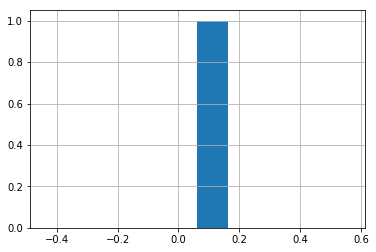

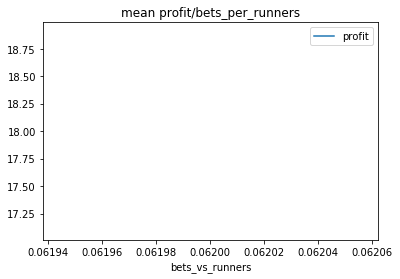

In [67]:
# bets/runners
df['bets_vs_runners'] = df.num_bets / df.num_runners
df['bets_vs_runners'].hist(bins=10)
groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

In [68]:
# # pred vs scale
# df['prob_vs_scale'] = df.pr / df.num_runners
# df['bets_vs_runners'].hist(bins=10)
# groups = df.groupby(df['bets_vs_runners'].apply(lambda x: round(x, 3))).sum()
# groups.plot(kind='line', y='profit', title='mean profit/bets_per_runners')

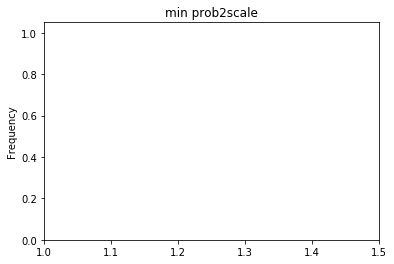

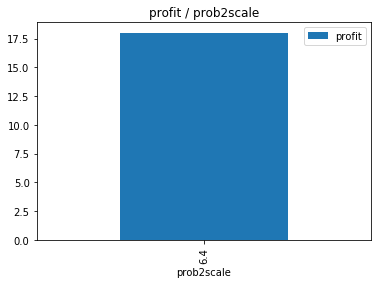

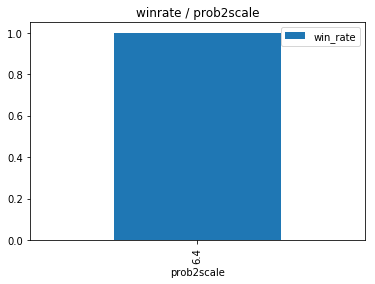

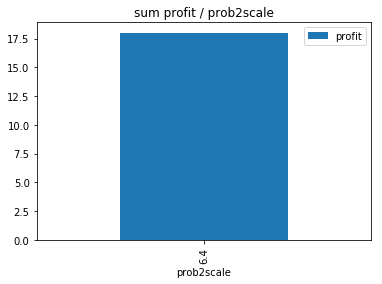

In [69]:
df.prob2scale.plot(kind='hist', bins=500, title='min prob2scale', xlim=(1, 1.5))
groups = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).mean()
groups.plot(kind='bar', y='profit', title='profit / prob2scale')
groups.plot(kind='bar', y='win_rate', title='winrate / prob2scale')

groups_sum = df.groupby(df['prob2scale'].apply(lambda x: round(x, 1))).sum()
groups_sum.plot(kind='bar', y='profit', title='sum profit / prob2scale')

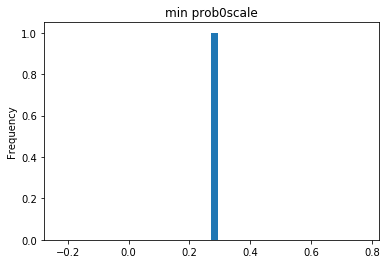

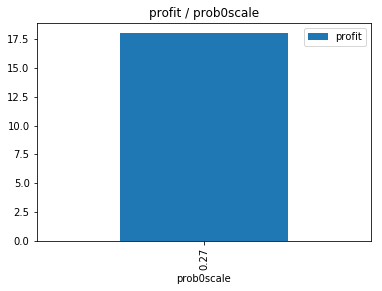

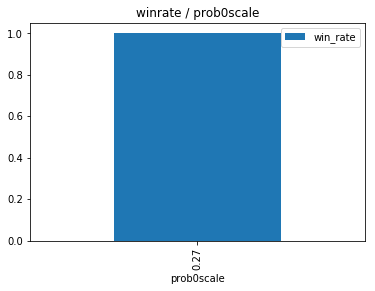

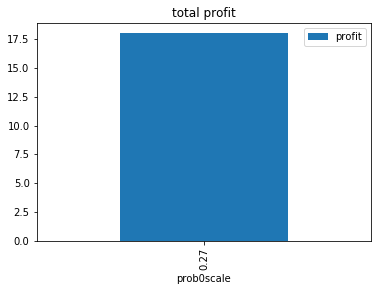

In [70]:
df.prob0scale.plot(kind='hist', bins=50, title='min prob0scale')
groups = df.groupby(df['prob0scale'].apply(lambda x: round(x, 2))).mean()
groups.plot(kind='bar', y='profit', title='profit / prob0scale')
groups.plot(kind='bar', y='win_rate', title='winrate / prob0scale')

groups_sum = df.groupby(df['prob0scale'].apply(lambda x: round(x, 2))).sum()
groups_sum.plot(kind='bar', y='profit', title='total profit')